In [2]:
import os, io, re, zipfile
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
INPUT_ZIP = r"input\Arkhiv_pogody.zip" 
OUT_DIR = r"output"
os.makedirs(OUT_DIR, exist_ok=True)


In [4]:
RU_MONTHS = {
    "января": 1, "февраля": 2, "марта": 3, "апреля": 4, "мая": 5, "июня": 6,
    "июля": 7, "августа": 8, "сентября": 9, "октября": 10, "ноября": 11, "декабря": 12
}

def parse_ru_date(s: str):
    # пример: "2024г. 19 января, пятница" (иногда с неразрывными пробелами)
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return None
    s = str(s).replace("\xa0", " ").strip().lower()
    m = re.search(r"(\d{4})\s*г\.\s*(\d{1,2})\s*([а-я]+)", s)
    if not m:
        return None
    y = int(m.group(1))
    d = int(m.group(2))
    mon = RU_MONTHS.get(m.group(3))
    if mon is None:
        return None
    return datetime(y, mon, d).date()

def to_float(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    s = str(x).strip().lower()
    s = s.replace(",", ".")
    s = re.sub(r"[^0-9\.\-]", "", s)
    if s in ("", ".", "-", "-."):
        return np.nan
    try:
        return float(s)
    except:
        return np.nan

def make_unique(cols):
    seen = {}
    out = []
    for c in cols:
        c = str(c).strip()
        if c not in seen:
            seen[c] = 0
            out.append(c)
        else:
            seen[c] += 1
            out.append(f"{c}.{seen[c]}")
    return out

def find_metar_table(tables):
    needed = {"T","Po","U","DD","Ff","WW","VV","Td"}
    for t in tables:
        if t.shape[0] < 3 or t.shape[1] < 8:
            continue
        header = set(str(x).strip() for x in t.iloc[0].tolist())
        if needed.issubset(header):
            return t
    return None

def airport_from_title(html_text: str) -> str:
    # вытаскиваем название аэропорта из <title>
    m = re.search(r"<title>(.*?)</title>", html_text, flags=re.IGNORECASE|re.DOTALL)
    if not m:
        return "Unknown"
    title = re.sub(r"\s+", " ", m.group(1)).strip()
    title = title.replace("Архив погоды в ", "").replace(", METAR", "").strip()
    return title

def parse_one_html(html_text: str) -> pd.DataFrame:
    tables = pd.read_html(io.StringIO(html_text))
    metar = find_metar_table(tables)
    if metar is None:
        return pd.DataFrame()

    cols = make_unique(metar.iloc[0].tolist())
    df = metar.iloc[1:].copy()
    df.columns = cols

    # Дата/время обычно в первых двух колонках
    date_col = "Дата / Местное время"
    time_col = "Дата / Местное время.1"
    if date_col not in df.columns: date_col = df.columns[0]
    if time_col not in df.columns: time_col = df.columns[1]

    df[date_col] = df[date_col].ffill()
    days = df[date_col].apply(parse_ru_date)
    times = df[time_col].astype(str).str.replace("\xa0"," ").str.strip()

    dt = []
    for d, t in zip(days, times):
        if d is None or t.lower() in ("nan",""):
            dt.append(pd.NaT)
            continue
        try:
            hh, mm = t.split(":")
            dt.append(datetime(d.year, d.month, d.day, int(hh), int(mm)))
        except:
            dt.append(pd.NaT)

    df["datetime_local"] = pd.to_datetime(dt, errors="coerce")
    return df

def load_module1(zip_path: str) -> pd.DataFrame:
    frames = []
    with zipfile.ZipFile(zip_path) as z:
        html_files = [n for n in z.namelist() if n.lower().endswith(".html")]
        print("HTML файлов в архиве:", len(html_files))
        for name in sorted(html_files):
            text = z.read(name).decode("utf-8", errors="ignore")
            airport = airport_from_title(text)
            df = parse_one_html(text)
            if df.empty:
                print("Не нашёл таблицу METAR в:", name)
                continue
            df["airport"] = airport
            frames.append(df)
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

raw = load_module1(INPUT_ZIP)
raw.shape, raw.columns


HTML файлов в архиве: 8


((1123, 16),
 Index(['Дата / Местное время', 'Дата / Местное время.1', 'T', 'Po', 'P', 'U',
        'DD', 'Ff', 'ff10', 'WW', 'W'W'', 'c', 'VV', 'Td', 'datetime_local',
        'airport'],
       dtype='object'))

In [5]:
df = raw.copy()

rename = {
    "T": "temp_C",
    "U": "humidity_pct",
    "Po": "pressure_station",
    "P": "pressure_sea",
    "Ff": "wind_speed",
    "DD": "wind_dir",
    "ff10": "wind_gust_10",
    "WW": "weather",
    "VV": "visibility_km",
    "Td": "dewpoint_C",
    "c": "clouds",
    "W'W'": "weather_add",
}
df = df.rename(columns=rename)

# числовые колонки
for c in ["temp_C","humidity_pct","pressure_station","pressure_sea","wind_speed","wind_gust_10","visibility_km","dewpoint_C"]:
    if c in df.columns:
        df[c] = df[c].apply(to_float)

before = len(df)
df = df.dropna(subset=["datetime_local", "temp_C"]).drop_duplicates()
df = df.sort_values(["airport","datetime_local"]).reset_index(drop=True)

print("Строк было -> стало:", before, "->", len(df))
df.head(3)


Строк было -> стало: 1123 -> 104


,Дата / Местное время,Дата / Местное время.1,temp_C,pressure_station,pressure_sea,humidity_pct,wind_dir,wind_speed,wind_gust_10,weather,weather_add,clouds,visibility_km,dewpoint_C,datetime_local,airport
0,"2024г. 19 января, пятница",00:00,-17.0,748.9,750.8,85.0,"Ветер, дующий с востока",4.0,NaN,NaN,NaN,Незначительная (10-30%) 990 м,10.0,-19.0,2024-01-19 00:00:00,Архангельске / им. Ф. А. Абрамова (аэропорт)
1,"2024г. 19 января, пятница",00:30,-16.0,748.2,750.1,85.0,"Ветер, дующий с востоко-юго-востока",4.0,NaN,NaN,NaN,Рассеянная (40-50%) 990 м,10.0,-18.0,2024-01-19 00:30:00,Архангельске / им. Ф. А. Абрамова (аэропорт)
2,"2024г. 19 января, пятница",01:00,-14.0,747.4,749.3,78.0,"Ветер, дующий с юго-востока",5.0,NaN,NaN,NaN,Рассеянная (40-50%) 990 м,10.0,-17.0,2024-01-19 01:00:00,Архангельске / им. Ф. А. Абрамова (аэропорт)


In [6]:
df["temp_diff_prev"] = df.groupby("airport")["temp_C"].diff()

def wind_cat(x):
    if pd.isna(x): return np.nan
    if x <= 3: return "calm"
    if x <= 8: return "moderate"
    return "strong"

df["wind_category"] = df["wind_speed"].apply(wind_cat)
df[["airport","datetime_local","temp_C","temp_diff_prev","wind_speed","wind_category"]].head(8)


,airport,datetime_local,temp_C,temp_diff_prev,wind_speed,wind_category
0,Архангельске / им. Ф. А. Абрамова (аэропорт),2024-01-19 00:00:00,-17.0,NaN,4.0,moderate
1,Архангельске / им. Ф. А. Абрамова (аэропорт),2024-01-19 00:30:00,-16.0,1.0,4.0,moderate
2,Архангельске / им. Ф. А. Абрамова (аэропорт),2024-01-19 01:00:00,-14.0,2.0,5.0,moderate
3,Архангельске / им. Ф. А. Абрамова (аэропорт),2024-01-19 01:30:00,-14.0,0.0,6.0,moderate
4,Архангельске / им. Ф. А. Абрамова (аэропорт),2024-01-19 02:00:00,-13.0,1.0,6.0,moderate
5,Архангельске / им. Ф. А. Абрамова (аэропорт),2024-01-19 02:30:00,-13.0,0.0,6.0,moderate
6,Архангельске / им. Ф. А. Абрамова (аэропорт),2024-01-19 03:00:00,-12.0,1.0,7.0,moderate
7,Архангельске / им. Ф. А. Абрамова (аэропорт),2024-01-19 03:30:00,-12.0,0.0,8.0,moderate


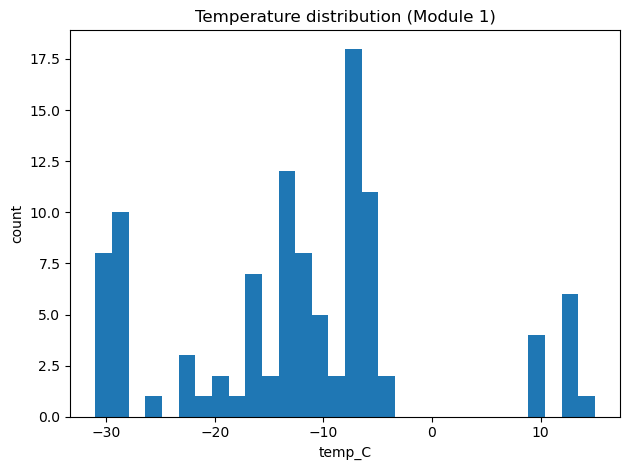

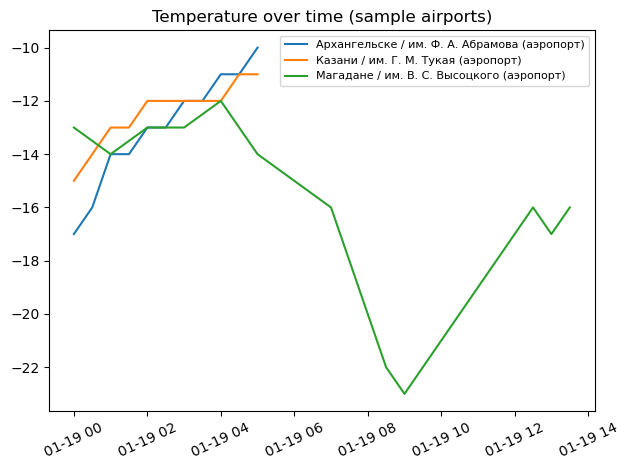

<Figure size 640x480 with 0 Axes>

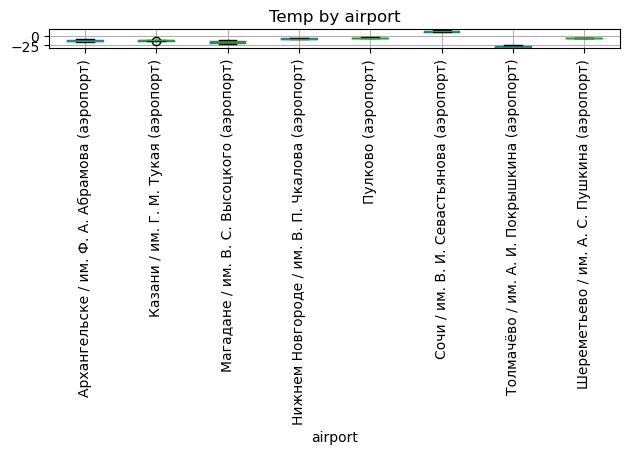

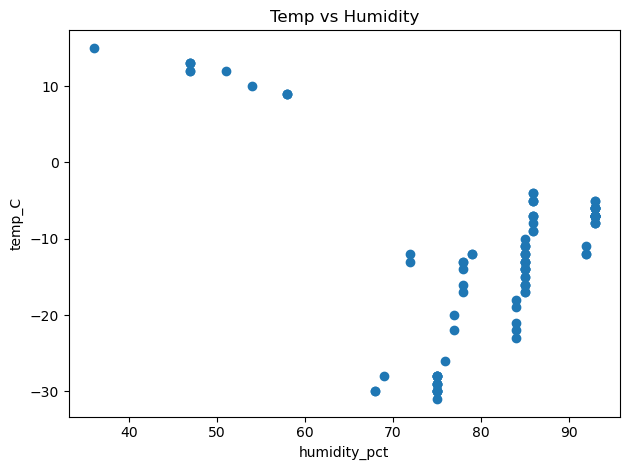

In [7]:
# 1) распределение температуры
plt.figure()
df["temp_C"].dropna().plot(kind="hist", bins=30)
plt.title("Temperature distribution (Module 1)")
plt.xlabel("temp_C")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# 2) температура по времени (3 аэропорта)
plt.figure()
for a in df["airport"].unique()[:3]:
    tmp = df[df["airport"] == a]
    plt.plot(tmp["datetime_local"], tmp["temp_C"], label=a)
plt.title("Temperature over time (sample airports)")
plt.xticks(rotation=25)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# 3) boxplot по аэропортам
plt.figure()
df.boxplot(column="temp_C", by="airport", rot=90)
plt.title("Temp by airport")
plt.suptitle("")
plt.tight_layout()
plt.show()

# 4) scatter temp vs humidity
plt.figure()
plt.scatter(df["humidity_pct"], df["temp_C"])
plt.title("Temp vs Humidity")
plt.xlabel("humidity_pct")
plt.ylabel("temp_C")
plt.tight_layout()
plt.show()


In [8]:
out_csv = os.path.join(OUT_DIR, "data_m1.csv")
df.to_csv(out_csv, index=False, encoding="utf-8")

out_zip = os.path.join(OUT_DIR, "Data.zip")
with zipfile.ZipFile(out_zip, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(out_csv, arcname="data_m1.csv")

out_csv, out_zip


('output\\data_m1.csv', 'output\\Data.zip')